In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import talib  # For technical indicators

# Load the dataset

In [2]:
file_path = "question4-stock-data.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11291 non-null  int64  
 1   Date        11181 non-null  object 
 2   Adj Close   11198 non-null  float64
 3   Close       11174 non-null  float64
 4   High        11196 non-null  float64
 5   Low         11164 non-null  float64
 6   Open        11188 non-null  float64
 7   Volume      11146 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 705.8+ KB


,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [3]:
df.describe()

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
count,11291.000000,11198.000000,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,5645.000000,63.609130,72.026945,72.503100,71.665079,67.999259,2.144157e+05
std,3259.575279,52.266247,51.259828,51.550735,51.011632,55.834401,3.883662e+05
min,0.000000,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,2822.500000,19.224636,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,5645.000000,50.608900,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,8467.500000,104.723621,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,11290.000000,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07


In [4]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64


# Pre-process dataset

In [5]:
#Drop unwanted columns and rows
df.drop(columns=["Unnamed: 0"], inplace=True)

# Convert 'Date' to datetime format and sort by date
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)

df.dropna(subset=["Date"], inplace=True)  # Drop rows with missing dates

In [6]:
# Handle missing values
df.ffill(inplace=True)  # Forward fill
df.bfill(inplace=True)  # Backward fill

In [7]:
# Fill '0' values in 'Open' with the previous day's 'Close' price
df.loc[df["Open"] == 0, "Open"] = df["Close"].shift(1)

# Drop initial NaN values caused by rolling calculations
df = df.dropna()

In [8]:
#If volume 0 and no price change drop that rows by considering them as holidays
df = df[~((df["Volume"] == 0) & 
          (df["Open"] == df["High"]) & 
          (df["Open"] == df["Low"]) & 
          (df["Open"] == df["Close"]))]

In [9]:
#If volume 0 and price has changed, fill them with ffill
df.loc[(df["Volume"] == 0) & 
       ((df["Open"] != df["Close"]) | 
        (df["Open"] != df["High"]) | 
        (df["Open"] != df["Low"])), 
       ["Volume"]] = None

df.ffill(inplace=True)

# Drop initial NaN values caused by rolling calculations
df = df.dropna()

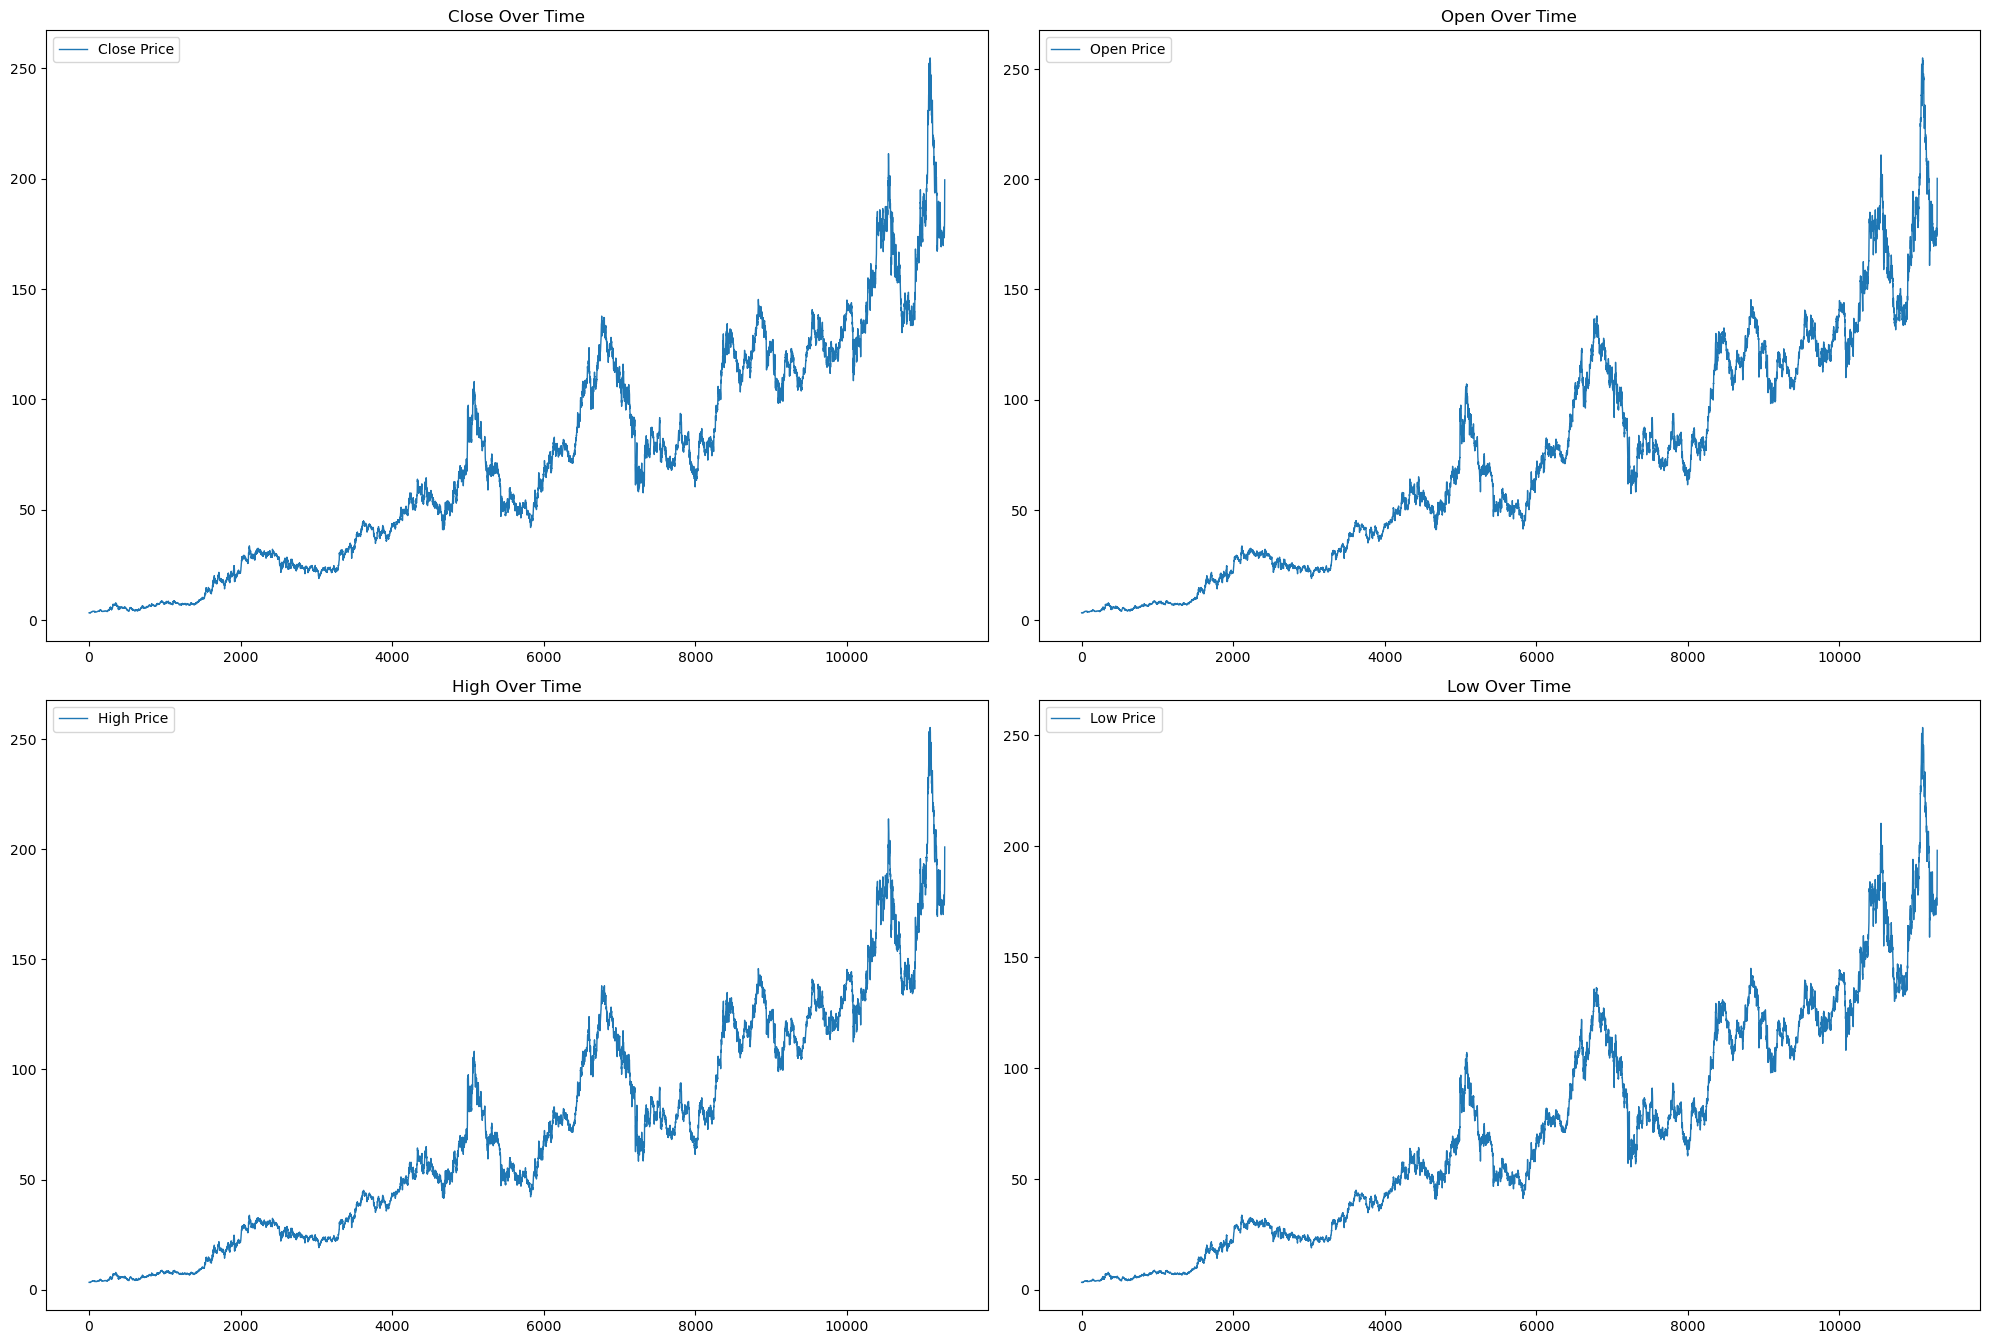

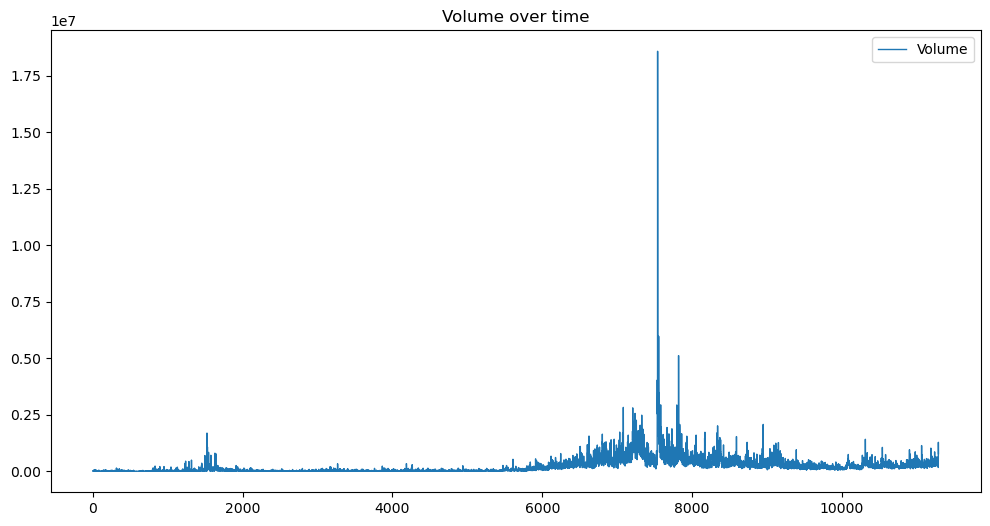

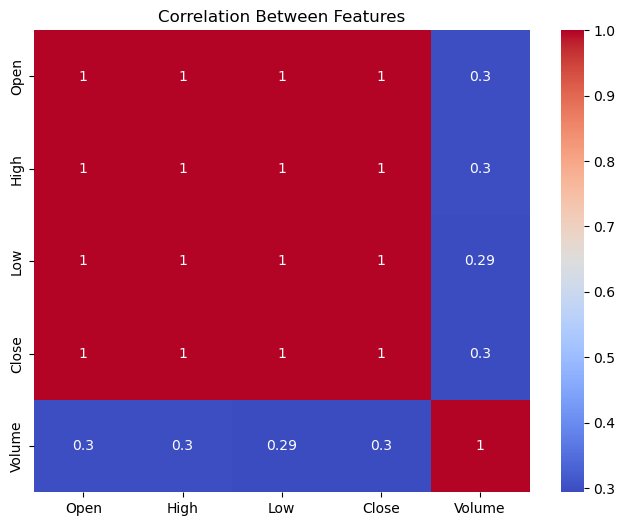

In [10]:
# Create a figure with multiple subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each field in a separate subplot
fields = ['Close', 'Open', 'High', 'Low']
for i, field in enumerate(fields):
    axes[i].plot(df[field], label=f'{field} Price', linewidth=1)
    axes[i].set_title(f'{field} Over Time')
    axes[i].legend()

# Hide the last subplot (if there are more subplots than fields)
if len(fields) < len(axes):
    for i in range(len(fields), len(axes)):
        fig.delaxes(axes[i])  # Hide unused subplots

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df['Volume'], label = f'Volume', linewidth = 1)
plt.title(f'Volume over time')
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()

# Feature Engineering

In [11]:
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()  # Exponential MA

df['RSI'] = talib.RSI(df['Close'].values, timeperiod=14)

# MACD
macd, macd_signal, _ = talib.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACD_Signal'] = macd_signal

# Bollinger Bands
upper, middle, lower = talib.BBANDS(df['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2)
df['BB_Upper'] = upper
df['BB_Lower'] = lower

# Rate of Change (Momentum Indicator)
df['ROC'] = talib.ROC(df['Close'], timeperiod=10)

# On-Balance Volume (OBV)
df['OBV'] = talib.OBV(df['Close'], df['Volume'])

# Lag Features (More Days for better trend capture)
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['Close'].shift(lag)

# Directional Target (Up = 1, Down = 0)
df['Price_Change'] = df['Close'].pct_change()
df['Direction'] = np.where(df['Price_Change'] > 0, 1, 0)  # 1 = Up, 0 = Down

# Future Target for Price Prediction
df['Target_Close_5d'] = df['Close'].shift(-5)

df = df.dropna()

## Charting engineered features

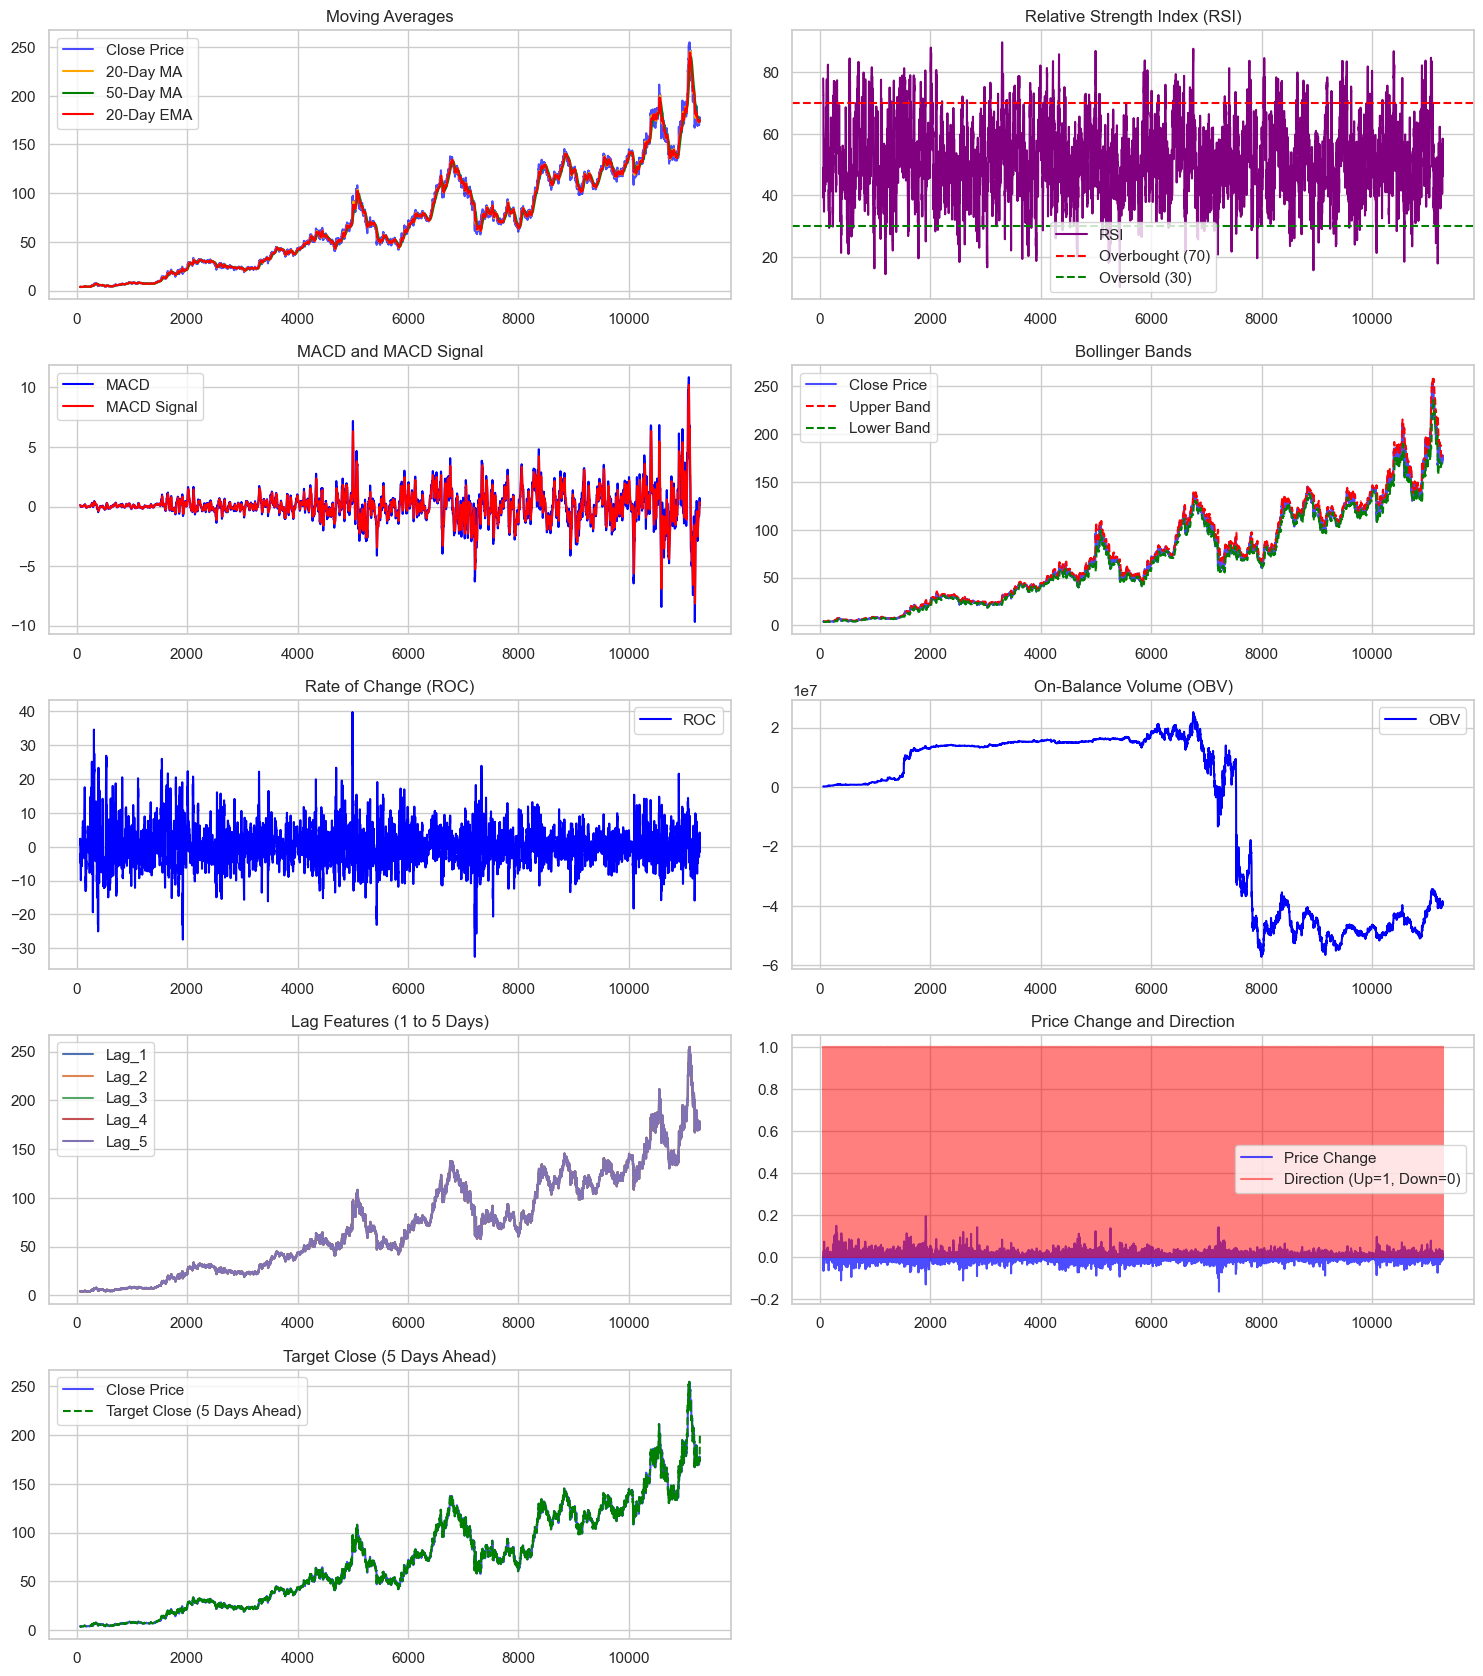

In [12]:
# Set up the plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 20))

# Plot 1: Moving Averages (MA_20, MA_50, EMA_20)
plt.subplot(6, 2, 1)
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['MA_20'], label='20-Day MA', color='orange')
plt.plot(df['MA_50'], label='50-Day MA', color='green')
plt.plot(df['EMA_20'], label='20-Day EMA', color='red')
plt.title('Moving Averages')
plt.legend()

# Plot 2: RSI
plt.subplot(6, 2, 2)
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Plot 3: MACD and MACD Signal
plt.subplot(6, 2, 3)
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['MACD_Signal'], label='MACD Signal', color='red')
plt.title('MACD and MACD Signal')
plt.legend()

# Plot 4: Bollinger Bands
plt.subplot(6, 2, 4)
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['BB_Upper'], label='Upper Band', color='red', linestyle='--')
plt.plot(df['BB_Lower'], label='Lower Band', color='green', linestyle='--')
plt.title('Bollinger Bands')
plt.legend()

# Plot 5: Rate of Change (ROC)
plt.subplot(6, 2, 5)
plt.plot(df['ROC'], label='ROC', color='blue')
plt.title('Rate of Change (ROC)')
plt.legend()

# Plot 6: On-Balance Volume (OBV)
plt.subplot(6, 2, 6)
plt.plot(df['OBV'], label='OBV', color='blue')
plt.title('On-Balance Volume (OBV)')
plt.legend()

# Plot 7: Lag Features (Lag_1 to Lag_5)
plt.subplot(6, 2, 7)
for lag in range(1, 6):
    plt.plot(df[f'Lag_{lag}'], label=f'Lag_{lag}')
plt.title('Lag Features (1 to 5 Days)')
plt.legend()

# Plot 8: Price Change and Direction
plt.subplot(6, 2, 8)
plt.plot(df['Price_Change'], label='Price Change', color='blue', alpha=0.7)
plt.plot(df['Direction'], label='Direction (Up=1, Down=0)', color='red', alpha=0.5)
plt.title('Price Change and Direction')
plt.legend()

# Plot 9: Target Close (5 Days Ahead)
plt.subplot(6, 2, 9)
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['Target_Close_5d'], label='Target Close (5 Days Ahead)', color='green', linestyle='--')
plt.title('Target Close (5 Days Ahead)')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [13]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,MA_20,MA_50,EMA_20,...,ROC,OBV,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Price_Change,Direction,Target_Close_5d
63,1980-06-16,2.838319,4.067208,4.120724,4.067208,4.053829,7474.0,3.938770,3.642292,3.918725,...,2.356900,171910.0,4.053829,4.040450,4.000313,3.973555,3.960176,0.003300,1,3.877226
64,1980-06-17,2.819647,4.040450,4.093966,4.040450,4.067208,934.0,3.950811,3.657008,3.930318,...,0.666673,170976.0,4.067208,4.053829,4.040450,4.000313,3.973555,-0.006579,0,3.750795
66,1980-06-19,2.819647,4.040450,4.093966,4.040450,4.040450,1869.0,3.958838,3.671725,3.940806,...,2.027034,170976.0,4.040450,4.067208,4.053829,4.040450,4.000313,0.000000,0,3.708651
67,1980-06-20,2.819647,4.040450,4.093966,4.040450,4.040450,1869.0,3.966866,3.684837,3.950296,...,2.372891,170976.0,4.040450,4.040450,4.067208,4.053829,4.040450,0.000000,0,3.708651
69,1980-06-24,2.632913,3.772870,3.826386,3.772870,4.040450,1869.0,3.961514,3.692329,3.933399,...,-4.729737,169107.0,4.040450,4.040450,4.040450,4.067208,4.053829,-0.066225,0,3.694603


### Define target and features

In [14]:
target = 'Target_Close_5d'
features = ['Close', 'MA_20', 'MA_50', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 
            'BB_Upper', 'BB_Lower', 'ROC', 'OBV', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Volume']

### Train-Test Split (Time Series)

In [15]:
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]

X_train = df_train[features].values
y_train = df_train[target].values
X_test  = df_test[features].values
y_test  = df_test[target].values

### Feature Scaling (Normalization)

In [16]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1))

### Reshape Data for LSTM (3D format: samples, timesteps, features)

In [17]:
time_steps = 5  # Use past 5 days to predict the next 5 days

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

## Model Selection
### Tested models: Linear Regression, Random Forest, and LSTM. Chose LSTM due to its ability to capture temporal dependencies in time series data.

### Build and train the LSTM Model

In [18]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_seq, y_train_seq, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test_seq, y_test_seq), 
                    verbose=1)

Epoch 1/50


c:\Users\ASUS TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0264 - val_loss: 0.0145
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 0.0163
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0151
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0174
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0204
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9980e-04 - val_loss: 0.0106
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9542e-04 - val_loss: 0.0186
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3427e-04 - val_loss: 0.0120
Epoch 9/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2617e-04 - val_loss: 0.0183
Epoch 10/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9341e-04 - val_loss: 0.0212
Epoch 11/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3350e-04 - val_loss: 0.0247
Epoch 12/50
276/276 ━━━━━━━━━━━━━━━━━━━

## Evaluate Model & Make Predictions

In [19]:
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Convert back to original scale
y_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [20]:
# Performance Metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)

# Directional Accuracy Calculation
direction_actual = np.sign(np.diff(y_actual.flatten()))  # Actual price movement (1 = up, -1 = down)
direction_pred = np.sign(np.diff(y_pred.flatten()))  # Predicted price movement (1 = up, -1 = down)

directional_accuracy = np.mean(direction_actual == direction_pred) * 100  # Percentage match

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Model Performance:
MAE: 24.1062
RMSE: 29.3561
Directional Accuracy: 50.57%


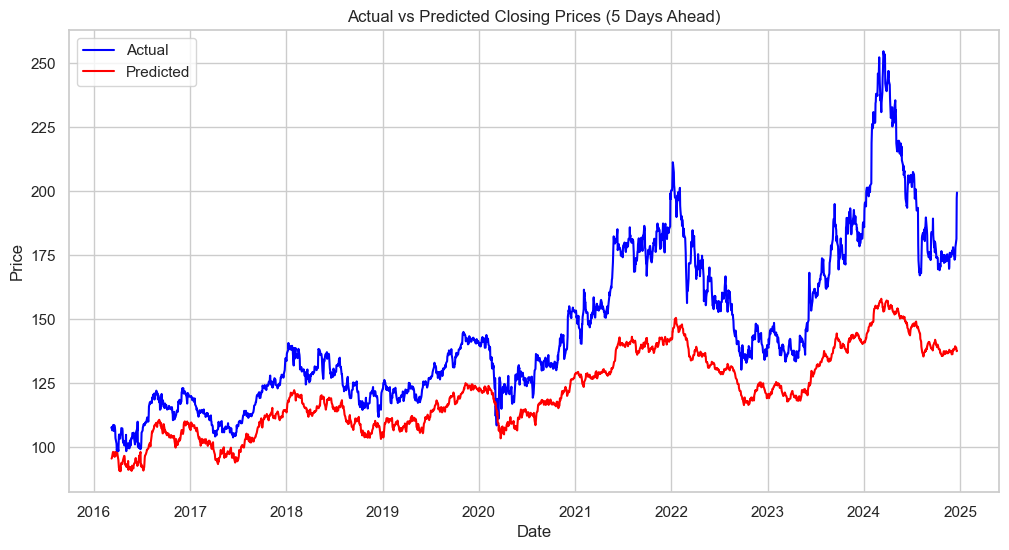

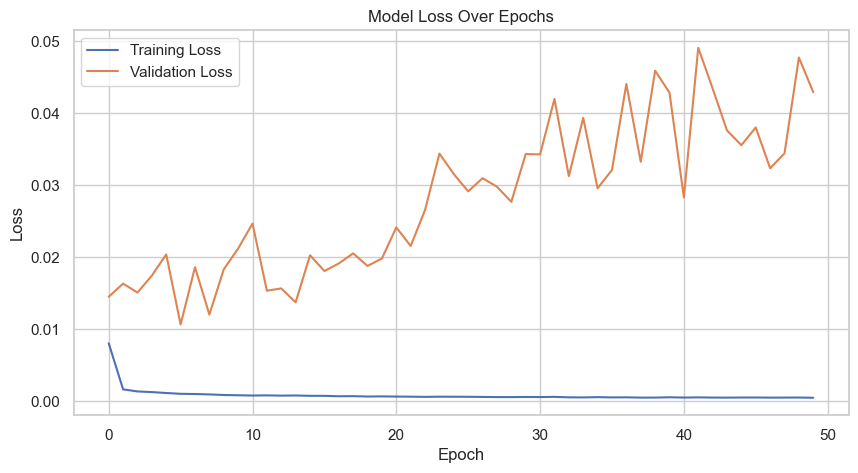

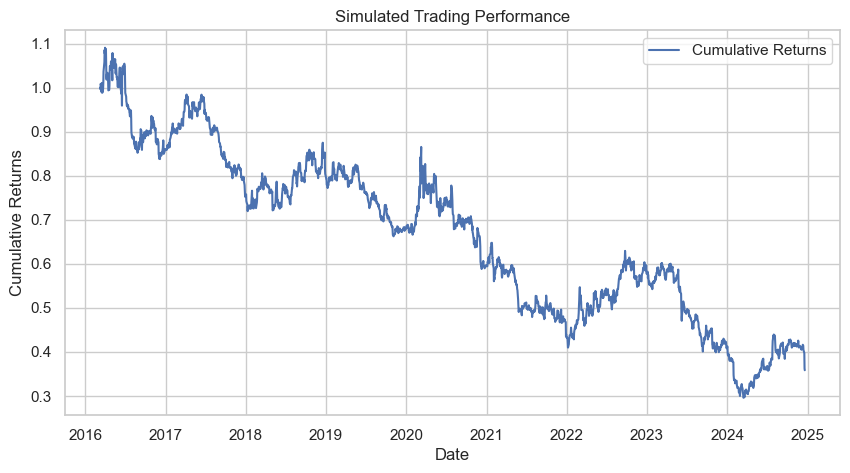

Total Return: -64.17%


In [21]:
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
directional_accuracy = np.mean(np.sign(y_actual[1:] - y_actual[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])) * 100

print(f"LSTM Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(df_test['Date'].iloc[time_steps:], y_actual, label='Actual', color='blue')
plt.plot(df_test['Date'].iloc[time_steps:], y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Closing Prices (5 Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Simulated Trading Performance
# Simulate a simple trading strategy: Buy if predicted price increases by >1%, sell if decreases by >1%.

test_df = df_test.iloc[time_steps:].copy()
test_df['Predicted_Close_5d'] = y_pred
test_df['Actual_Change'] = test_df['Target_Close_5d'].pct_change()
test_df['Pred_Change'] = (test_df['Predicted_Close_5d'] - test_df['Close']) / test_df['Close']

# Trading signals
test_df['Signal'] = np.where(test_df['Pred_Change'] > 0.01, 1, np.where(test_df['Pred_Change'] < -0.01, -1, 0))
test_df['Returns'] = test_df['Actual_Change'] * test_df['Signal'].shift(1)  # Shift signal to avoid lookahead bias
cumulative_returns = (1 + test_df['Returns'].fillna(0)).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(test_df['Date'], cumulative_returns, label='Cumulative Returns')
plt.title('Simulated Trading Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

print(f"Total Return: {(cumulative_returns.iloc[-1] - 1) * 100:.2f}%")

### Output Predictions

In [22]:
test_df[['Date', 'Close', 'Predicted_Close_5d', 'Target_Close_5d']].to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'
